# OPD Crimes Dataset

In this notebook, we're going to clean a dataset from the Orlando open data portal. You can download the dataset from [here](https://data.cityoforlando.net/Orlando-Police/OPD-Crimes/4y9m-jbmz). Click `Download` then `CSV`.

This file should be reachable from the directory you launched the Jupyter notebook. Ex: If the file is in `~/codex-python-workshop/data` (like the code repo)

```bash
cd ~/codex-python-workshop/data
jupyter notebook
```

Our first cell imports Pandas so we can start working.

In [1]:
import pandas as pd

Now we can read in our raw dataset. The filename should match what is on your computer.

In [2]:
opd = pd.read_csv("opd_crimes.csv")

## Overview

With the data loaded, let's take a quick look by displaying the frist five rows of data.

In [3]:
opd.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location
0,2013-00074238,02/19/2013 12:41:00 PM,200 Block of N TAMPA AVE,Commercial/Office Building,Assault,Simple assault,Committed,Closed,Mapped,"(28.54518403, -81.40556136)"
1,2014-00326276,08/06/2014 02:55:00 AM,8600 Block of ANDREAS AVE,Construction Site,Theft,All other larceny,Committed,Closed,Mapped,"(28.44153996, -81.23261223)"
2,2014-00451565,10/30/2014 10:15:00 PM,1900 Block of METROCENTER BV,Commercial/Office Building,Theft,All other larceny,Committed,Closed,Mapped,"(28.51884164, -81.46848512)"
3,2016-00007509,01/06/2016 10:39:00 AM,1500 Block of AARON AVE,School,Assault,Simple assault,Committed,Closed,Mapped,"(28.52377872, -81.43230433)"
4,2011-00442271,10/06/2011 06:55:00 AM,W JACKSON ST / S PARRAMORE AVE,Parking Lot - Surface,Assault,Simple assault,Attempted,Arrest,Mapped,"(28.53921282, -81.38900691)"


This is a great way to get an initial impression of what we need to do to clean our dataset.

Another way we can get an overview is by looking at the metadata.

In [4]:
opd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181260 entries, 0 to 181259
Data columns (total 10 columns):
Case Number                   181260 non-null object
Case Date Time                181258 non-null object
Case Location                 181260 non-null object
Case Offense Location Type    181260 non-null object
Case Offense Category         181260 non-null object
Case Offense Type             181260 non-null object
Case Offense Charge Type      181260 non-null object
Case Disposition              181260 non-null object
Status                        181260 non-null object
Location                      174368 non-null object
dtypes: object(10)
memory usage: 13.8+ MB


## Meta Cleaning

### Column Names

Let's start by cleaning the data structure itself. First let's look at the column names.

In [5]:
opd.columns

Index(['Case Number', 'Case Date Time', 'Case Location',
       'Case Offense Location Type', 'Case Offense Category',
       'Case Offense Type', 'Case Offense Charge Type', 'Case Disposition',
       'Status', 'Location'],
      dtype='object')

We could work with the column names as is, or we could make them easier to call from Python's dot syntax. Column names with spaces in them can only be accessed using the dictionary syntax:

```python
opd["Case Number"]
```

If we rename and replace the space, we could access the same column with dot syntax:

```python
opd.case_number
```

Let's replace some column names first.

In [6]:
opd.rename(columns={
    "Case Date Time": "timestamp",
    "Case Location": "address",
    "Location": "coordinate",
}, inplace=True)

Note the `inplace=True` in this call. By default, actions on a dataframe return a copy of the object. Using `inplace` changes the dataframe itself. Otherwise, we'd have to overwrite the dataframe:

```python
opd = opd.rename(columns=values)
```

Let's clean the remaining column names by running some string operations on the entire series.

In [7]:
opd.columns = opd.columns.str.lower().str.replace(" ", "_").str.replace("case_", "")

Let's take a look at our resulting column names.

In [8]:
opd.columns

Index(['number', 'timestamp', 'address', 'offense_location_type',
       'offense_category', 'offense_type', 'offense_charge_type',
       'disposition', 'status', 'coordinate'],
      dtype='object')

These will be much easier to use in this notebook and when we build our database.

### Data Removal

There are a few data cleaning methods that are valuable regardless of the context. We'll first delete duplicate rows and remove rows that contain any null values.

In [9]:
print("Original number of rows:", len(opd))
opd.drop_duplicates(inplace=True)
print("After removing duplicate data:", len(opd))
opd.dropna(inplace=True)
print("After removing null data:", len(opd))

Original number of rows: 181260
After removing duplicate data: 181260
After removing null data: 174368


There were no duplicate rows, but we just removed 7k rows that had missing coordinate values. We can see this in the `opd.info()` call above where every column had non-null data except for coordinates (formerly Location).

Now let's look at the data values themselves. We have a lot of categorical data in this dataset. Here's all of the possible values for the case offense categories.

In [10]:
opd.offense_category.unique()

array(['Assault', 'Theft', 'Narcotics', 'Burglary', 'Vehicle Theft',
       'Fraud', 'Robbery', 'Homicide', 'Arson', 'Embezzlement',
       'Kidnapping', 'Bribery'], dtype=object)

This information would be useful for querying our data later on. However, take a look at the unique values of case status.

In [11]:
opd.status.unique()

array(['Mapped'], dtype=object)

There's only one possible value in this column, which doesn't make this column useful to us at all. It's just taking up space. Let's just remove this entire column.

In [12]:
opd.drop(columns="status", inplace=True)

We can see the column was successfully removed.

In [13]:
opd.columns

Index(['number', 'timestamp', 'address', 'offense_location_type',
       'offense_category', 'offense_type', 'offense_charge_type',
       'disposition', 'coordinate'],
      dtype='object')

## Data Cleaning

### Coordinates

Let's see the current state of the dataset now that we've renamed columns and removed data.

In [14]:
opd.head()

,number,timestamp,address,offense_location_type,offense_category,offense_type,offense_charge_type,disposition,coordinate
0,2013-00074238,02/19/2013 12:41:00 PM,200 Block of N TAMPA AVE,Commercial/Office Building,Assault,Simple assault,Committed,Closed,"(28.54518403, -81.40556136)"
1,2014-00326276,08/06/2014 02:55:00 AM,8600 Block of ANDREAS AVE,Construction Site,Theft,All other larceny,Committed,Closed,"(28.44153996, -81.23261223)"
2,2014-00451565,10/30/2014 10:15:00 PM,1900 Block of METROCENTER BV,Commercial/Office Building,Theft,All other larceny,Committed,Closed,"(28.51884164, -81.46848512)"
3,2016-00007509,01/06/2016 10:39:00 AM,1500 Block of AARON AVE,School,Assault,Simple assault,Committed,Closed,"(28.52377872, -81.43230433)"
4,2011-00442271,10/06/2011 06:55:00 AM,W JACKSON ST / S PARRAMORE AVE,Parking Lot - Surface,Assault,Simple assault,Attempted,Arrest,"(28.53921282, -81.38900691)"


Looking good so far.

Our coordinate column is not too useful to us right now. It would be easier to query coordinate data if they were split into latitude and longitude float values.

In [15]:
opd.coordinate

0         (28.54518403, -81.40556136)
1         (28.44153996, -81.23261223)
2         (28.51884164, -81.46848512)
3         (28.52377872, -81.43230433)
4         (28.53921282, -81.38900691)
                     ...             
181255    (28.60561255, -81.44706923)
181256    (28.50884371, -81.46514312)
181257    (28.57798444, -81.44635373)
181258    (28.54308365, -81.37905511)
181259    (28.47391409, -81.44958996)
Name: coordinate, Length: 174368, dtype: object

Our coordinate values are strings that look like this:

`(28.54518403, -81.40556136)`

In order to parse this string, we need to perform these steps to each value:

- Remove the parentheses from each end (`.strip("()")`)
- Split the values separated by `", "` (`.split(", ")`)
- Cast each value from string to a float (`float(value)`)

Once we have two lists, we'll create these new columns and remove the old one.

In [16]:
lats, lons = [] , []

for coord in opd.coordinate:
    lat, lon = coord.strip("()").split(", ")
    lats.append(float(lat))
    lons.append(float(lon))

opd["latitude"] = lats
opd["longitude"] = lons
opd.drop(columns="coordinate", inplace=True)

And verify that the loop worked.

In [17]:
opd.latitude

0         28.545184
1         28.441540
2         28.518842
3         28.523779
4         28.539213
            ...    
181255    28.605613
181256    28.508844
181257    28.577984
181258    28.543084
181259    28.473914
Name: latitude, Length: 174368, dtype: float64

The coordinates are now separated and cast to floats. We can verify that by looking at the columns data type: `dtype: float64`. This means that every value in this column is a float.

### Timestamp

The other values that we should clean up is the American-formatted timestamp. We'd rather these be stored as native datetime objects to make querying easier to do.

In [18]:
opd.timestamp

0         02/19/2013 12:41:00 PM
1         08/06/2014 02:55:00 AM
2         10/30/2014 10:15:00 PM
3         01/06/2016 10:39:00 AM
4         10/06/2011 06:55:00 AM
                   ...          
181255    02/13/2012 09:36:00 AM
181256    12/31/2012 11:17:00 AM
181257    02/06/2014 03:34:00 PM
181258    11/08/2013 02:39:00 PM
181259    06/24/2015 09:05:00 PM
Name: timestamp, Length: 174368, dtype: object

It is possible to let Pandas parse these values itself using `pd.to_datetime`, but it can be pretty slow having to determine the appropriate format for each value. Instead, adding an explicit format string will make it run much faster.

- `"02/19/2013 12:41:00 PM"`
- `"%m/%d/%Y %I:%M:%S %p"

For more info on these format characters, check out the [datetime documentation](https://docs.python.org/3.7/library/datetime.html#strftime-and-strptime-behavior).

In [19]:
opd.timestamp = pd.to_datetime(opd.timestamp, format="%m/%d/%Y %I:%M:%S %p")

## Export Data

Before we save this new data out to disk, it's a good idea to take one last look at our final dataset as a gut check.

In [20]:
opd.head()

,number,timestamp,address,offense_location_type,offense_category,offense_type,offense_charge_type,disposition,latitude,longitude
0,2013-00074238,2013-02-19 12:41:00,200 Block of N TAMPA AVE,Commercial/Office Building,Assault,Simple assault,Committed,Closed,28.545184,-81.405561
1,2014-00326276,2014-08-06 02:55:00,8600 Block of ANDREAS AVE,Construction Site,Theft,All other larceny,Committed,Closed,28.441540,-81.232612
2,2014-00451565,2014-10-30 22:15:00,1900 Block of METROCENTER BV,Commercial/Office Building,Theft,All other larceny,Committed,Closed,28.518842,-81.468485
3,2016-00007509,2016-01-06 10:39:00,1500 Block of AARON AVE,School,Assault,Simple assault,Committed,Closed,28.523779,-81.432304
4,2011-00442271,2011-10-06 06:55:00,W JACKSON ST / S PARRAMORE AVE,Parking Lot - Surface,Assault,Simple assault,Attempted,Arrest,28.539213,-81.389007


Looks good to me. Saving the data is just as easy as loading it. Make sure you give a different filename though.

In [21]:
opd.to_csv("clean_opd.csv")

## Bonus Graphs!

Graphs are a great way to quickly view a large quantity of data. We're not going to do anything too complex here though.

Make sure you have pip installed `matplotlib` to create these first two graphs.

First let's look at our charge type values and how often they occur.

In [22]:
oct_counts = opd.offense_charge_type.value_counts()
oct_counts

Committed    164993
Attempted      9375
Name: offense_charge_type, dtype: int64

For every 20 crimes in this dataset, only 1 wasn't considdered successful. We can quickly visualize this because `pandas` integrates nicely with the `matplotlib` library.

In [23]:
oct_counts.plot.bar()

For a better example, there are more offense categories for us to plot.

In [24]:
opd.offense_category.value_counts()

Theft            86706
Burglary         25129
Assault          19022
Narcotics        18299
Fraud            11255
Vehicle Theft     8627
Robbery           4828
Arson              236
Homicide           140
Kidnapping          87
Embezzlement        38
Bribery              1
Name: offense_category, dtype: int64

Half of all crimes in this dataset are thefts. Plotting these counts makes it easier for us to compare their relative values.

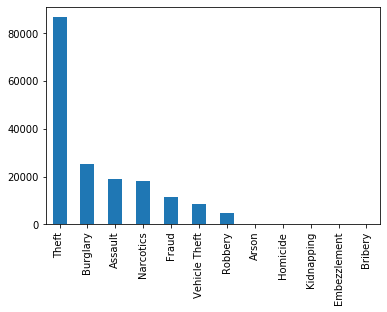

In [25]:
opd.offense_category.value_counts().plot.bar()

And now for a more complex example. We can use the `bokeh` library to create interactive graphs. We can simulate a geo-coordinate map by creating a scatterplot with longitude as the x-axis and latitude as the y-axis.

In [26]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

We first create the empty plot where the axes are bound by our coordinate minimum and maximum values. If we wanted to make this more accurate, we could make the axes have the same length to reduce distortions, but this should suffice.

In [27]:
# create a new plot with the tools above, and explicit ranges
p = figure(
    x_range=(opd.longitude.min(), opd.longitude.max()),
    y_range=(opd.latitude.min(), opd.latitude.max())
)

# add a circle renderer with vectorized colors and sizes
p.circle(opd.longitude, opd.latitude, fill_alpha=0.6, line_color=None)

# show the results
show(p)

## Bonus Queries!

A dataset isn't very useful if you can't query the data inside. Pandas makes this very easy now that we've cleaned the dataset with native Python types.

For example, we can query the dataset to return only assults.

In [28]:
opd[opd.offense_category == "Assault"].head()

,number,timestamp,address,offense_location_type,offense_category,offense_type,offense_charge_type,disposition,latitude,longitude
0,2013-00074238,2013-02-19 12:41:00,200 Block of N TAMPA AVE,Commercial/Office Building,Assault,Simple assault,Committed,Closed,28.545184,-81.405561
3,2016-00007509,2016-01-06 10:39:00,1500 Block of AARON AVE,School,Assault,Simple assault,Committed,Closed,28.523779,-81.432304
4,2011-00442271,2011-10-06 06:55:00,W JACKSON ST / S PARRAMORE AVE,Parking Lot - Surface,Assault,Simple assault,Attempted,Arrest,28.539213,-81.389007
21,2015-00010028,2015-01-08 00:44:00,5000 Block of MILLENIA BV,Apartment/Condo,Assault,Simple assault,Committed,Arrest,28.478745,-81.442270
31,2011-00078986,2011-02-18 18:25:00,2500 Block of W COLONIAL DR,Parking Lot - Surface,Assault,Aggravated assault,Committed,Closed,28.552819,-81.412295


We can also chain filters together, so let's get some assults that happen in schools.

In [29]:
opd[opd.offense_category == "Assault"][opd.offense_location_type == "School"].head()

/Users/mdupont/anaconda3/envs/ws/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,number,timestamp,address,offense_location_type,offense_category,offense_type,offense_charge_type,disposition,latitude,longitude
3,2016-00007509,2016-01-06 10:39:00,1500 Block of AARON AVE,School,Assault,Simple assault,Committed,Closed,28.523779,-81.432304
55,2012-00225660,2012-05-29 14:53:00,3100 Block of EDGEWATER DR,School,Assault,Simple assault,Committed,Inactive,28.578863,-81.389561
322,2016-00035513,2016-01-25 14:35:00,6000 Block of S GOLDENROD RD,School,Assault,Simple assault,Committed,Closed,28.475263,-81.289789
647,2014-00477410,2014-11-18 10:25:00,800 Block of E ROBINSON ST,School,Assault,Simple assault,Committed,Arrest,28.545759,-81.367726
961,2012-00427539,2012-10-15 11:34:00,13700 Block of NARCOOSSEE RD,School,Assault,Simple assault,Committed,Inactive,28.369091,-81.244432


We can also take advatage of our datetime objects to search for assults that have happened since Christmas 2017.

In [30]:
from datetime import datetime

xmas = datetime(year=2017, month=12, day=25)
opd[opd.offense_category == "Assault"][xmas < opd.timestamp]

/Users/mdupont/anaconda3/envs/ws/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,number,timestamp,address,offense_location_type,offense_category,offense_type,offense_charge_type,disposition,latitude,longitude
457,2017-00510332,2017-12-29 17:27:00,3000 Block of E COLONIAL DR,Highway/Road/Alley,Assault,Simple assault,Committed,Closed,28.553312,-81.345277
2364,2017-00508481,2017-12-28 09:18:00,800 Block of W JACKSON ST,Apartment/Condo,Assault,Simple assault,Committed,Inactive,28.539192,-81.391911
2643,2017-00505069,2017-12-25 09:53:00,2000 Block of W JACKSON ST,Residence/Single,Assault,Simple assault,Committed,Inactive,28.539227,-81.406495
2802,2017-00504794,2017-12-25 00:42:00,4700 Block of PIEDMONT CT,Residence/Single,Assault,Aggravated assault,Committed,Inactive,28.530530,-81.441933
4545,2017-00507358,2017-12-27 12:50:00,6300 Block of HOLLYWOOD WAY,Hotel/Motel,Assault,Simple assault,Committed,Arrest,28.469742,-81.468704
24676,2017-00508645,2017-12-28 11:49:00,1800 Block of E MICHIGAN ST,Governemnt Building or Property,Assault,Simple assault,Committed,Inactive,28.513181,-81.356698
35087,2017-00507471,2017-12-27 14:14:00,6300 Block of BUFORD ST,Parking Lot - Surface,Assault,Simple assault,Committed,Closed,28.506184,-81.468183
36322,2017-00506649,2017-12-26 21:17:00,400 Block of N ORANGE BLOSSOM TRL,Parking Lot - Surface,Assault,Simple assault,Committed,Inactive,28.548384,-81.397364
42019,2017-00506297,2017-12-26 15:35:00,3100 Block of W PRINCETON ST,Other,Assault,Simple assault,Committed,Inactive,28.569728,-81.418917
50940,2017-00508704,2017-12-28 12:45:00,800 Block of W JACKSON ST,Apartment/Condo,Assault,Simple assault,Committed,Inactive,28.539192,-81.391911


And that's it! Now that we have a clean dataset, we can use `models.py` to insert this data into a brand new, local database.